# _Variational Autoencoder_: PyTorch & MNIST - _Dense_ layers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
print(f"torch version: {torch.__version__}")

torch version: 1.10.0+cu111


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: Tesla K80


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters-
num_epochs = 30
batch_size = 64
learning_rate = 0.001

### Load and pre-process MNIST dataset:

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])

In [ ]:
path_to_data = "C:\\Users\\Arjun\\Desktop\\VAE_resources\\"

In [ ]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        # root = path_to_data + "data", train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        # root = path_to_data + "data", train = False,
        transform = transforms_apply
        )


In [9]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [10]:
print(f"Sizes of train_dataset: {len(train_dataset)} and test_dataet: {len(test_dataset)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 938 and test_loader: 157


In [11]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 938 & len(test_loader) = 157


In [12]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(937.5, 156.25)

In [13]:
# Get some random batch of training images & labels-
images, labels = next(iter(train_loader))

# You get 64 images due to the specified batch size-
print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")

images.shape: torch.Size([64, 1, 28, 28]) & labels.shape: torch.Size([64])


In [14]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
images.reshape(-1, 28 * 28 * 1).shape

torch.Size([64, 784])

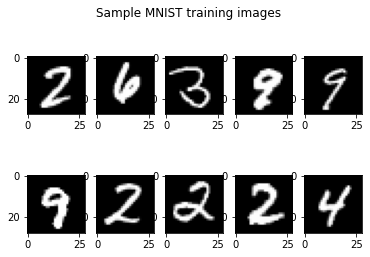

In [15]:
# Visualize 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0], cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample MNIST training images")
plt.show()

### _Variational Autoencoder_ architecture - _Dense_ layers

In [16]:
class VAE_Dense(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Dense, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.enc_layer1 = nn.Linear(
            in_features = 28 * 28 * 1, out_features = 512,
            bias = True
        )
        
        self.enc_layer2 = nn.Linear(
            in_features = 512, out_features = latent_space,
            bias = True
        )
        
        # Two additional layers 'hidden2mu' & 'hidden2log' to convert the bottleneck into the μ and σ vectors-
        self.hidden2mu = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        self.hidden2log_var = nn.Linear(in_features = latent_space, out_features = latent_space, bias = True)
        
        # Decoder-
        self.dec_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 512,
            bias = True
        )
        self.dec_layer2 = nn.Linear(
            in_features = 512, out_features = 28 * 28 * 1,
            bias = True
        )
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        sample = mu + (std * eps)
        
        return sample
    
    
    def forward(self, x):
        # Encode input data-
        x = F.relu(self.enc_layer1(x.view(-1, 28 * 28 * 1)))
        x = F.relu(self.enc_layer2(x))
        # NOTE: The line of code above does NOT give us the latent vector!
        
        # print(f"encoder's output x.shape: {x.shape}")
        
        mu = self.hidden2mu(x)
        log_var = self.hidden2log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        '''
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape} &"
              f" z.shape: {z.shape}")
        '''
        
        # Decode latent vector-
        x = F.relu(self.dec_layer1(z))
        recon_data = torch.sigmoid(self.dec_layer2(x)) # or, tanh
        
        return recon_data, mu, log_var
        

In [17]:
# Initialize a VAE objetc-
model = VAE_Dense(latent_space = 5).to(device)

In [18]:
print(model)

VAE_Dense(
  (enc_layer1): Linear(in_features=784, out_features=512, bias=True)
  (enc_layer2): Linear(in_features=512, out_features=5, bias=True)
  (hidden2mu): Linear(in_features=5, out_features=5, bias=True)
  (hidden2log_var): Linear(in_features=5, out_features=5, bias=True)
  (dec_layer1): Linear(in_features=5, out_features=512, bias=True)
  (dec_layer2): Linear(in_features=512, out_features=784, bias=True)
)


In [19]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([512, 784]) has 401408 parameters
layer.shape = torch.Size([512]) has 512 parameters
layer.shape = torch.Size([5, 512]) has 2560 parameters
layer.shape = torch.Size([5]) has 5 parameters
layer.shape = torch.Size([5, 5]) has 25 parameters
layer.shape = torch.Size([5]) has 5 parameters
layer.shape = torch.Size([5, 5]) has 25 parameters
layer.shape = torch.Size([5]) has 5 parameters
layer.shape = torch.Size([512, 5]) has 2560 parameters
layer.shape = torch.Size([512]) has 512 parameters
layer.shape = torch.Size([784, 512]) has 401408 parameters
layer.shape = torch.Size([784]) has 784 parameters


In [20]:
print(f"Total number of parameters in VAE Dense model = {tot_params}")

Total number of parameters in VAE Dense model = 809809


In [23]:
images = images.to(device)

In [24]:
images.shape

torch.Size([64, 1, 28, 28])

In [25]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [26]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([64, 784]), torch.Size([64, 5]), torch.Size([64, 5]))

In [27]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [28]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [29]:
# Reconstruction loss-
criterion = nn.BCELoss(reduction = 'sum')

# Note: reduction='sum' is used for the BCELoss(). If you read the PyTorch documentations, then this is
# specifically for the case of autoencoders only.

# Also, MSE loss could also be used-
# criterion = nn.MSELoss(reduction = 'sum')

In [30]:
def total_loss(reconstruction_loss, mu, log_var, alpha = 1):
    '''
    Function to add reconstruction loss and KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. recontruction loss - BCE or MSE loss
    2. mu: mean from the latent vector
    3. logvar: log variance from the latent vector
    4. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss.
    '''
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # final_loss = reconstruction_loss + KLD
    final_loss = (reconstruction_loss * alpha) + KLD
    
    return final_loss


In [31]:
def train_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    running_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader), total = int(len(train_dataset) / dataloader.batch_size)):
        data, _ = data
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        reconstruction, mu, logvar = model(data)
        
        # Compute reconstruction loss-
        bce_loss = criterion(reconstruction, data)
        
        # Compute final loss-
        loss = total_loss(bce_loss, mu, logvar, alpha)
        
        # Update loss-
        running_loss += loss.item()
        
        # Compute gradients wrt loss-
        loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    
    return train_loss


In [32]:
def validate_one_epoch(model, dataloader, alpha):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total = int(len(test_dataset) / dataloader.batch_size)):
            data, _ = data
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            data = data.view(data.size(0), -1)
            
            # Forward propagation-
            reconstruction, mu, logvar = model(data)
            
            # Compute reconstruction loss-
            bce_loss = criterion(reconstruction, data)
            
            # Compute total loss-
            loss = total_loss(bce_loss, mu, logvar, alpha)
            
            # Update loss-
            running_loss += loss.item()

            '''
            # save the last batch input and output of every epoch
            if i == int(len(test_dataset) / dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
            '''
            
    val_loss = running_loss / len(dataloader.dataset)
    
    return val_loss


In [ ]:
# Sanity check-
# train_loss = train_one_epoch(model = model, dataloader = train_loader, alpha = 1)

938it [00:29, 32.20it/s]                                                                                               


In [ ]:
# Sanity check-
# test_loss = validate_one_epoch(model = model, dataloader = test_loader, aplha = 1)

157it [00:02, 52.63it/s]                                                                                               


In [ ]:
print(f"train loss = {train_loss:.4f} & test loss = {test_loss:.4f}")

train loss = -21864.5813 & test loss = -28941.7061


In [33]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 10

In [34]:
# Python dict to contain training metrics-
train_history = {}

In [35]:
for epoch in range(1, 31):
    train_epoch_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha
    )
    val_epoch_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha
    )
    
    train_history[epoch] = {
        'train_loss': train_epoch_loss,
        'val_loss': val_epoch_loss
    }

    print(f"Epoch = {epoch}; train loss = {train_epoch_loss:.4f} & test loss = {val_epoch_loss:.4f}")
    

938it [00:19, 47.97it/s]                         
157it [00:02, 58.85it/s]                         


Epoch = 1; train loss = -179005.4882 & test loss = -212564.0966


938it [00:19, 48.19it/s]                         
157it [00:02, 59.53it/s]                         


Epoch = 2; train loss = -225596.5652 & test loss = -249905.5648


938it [00:19, 47.97it/s]
157it [00:02, 58.02it/s]                         


Epoch = 3; train loss = -259069.9915 & test loss = -270184.6774


938it [00:19, 47.99it/s]
157it [00:02, 58.09it/s]                         


Epoch = 4; train loss = -270098.3112 & test loss = -276598.5896


938it [00:19, 47.97it/s]                         
157it [00:02, 58.43it/s]                         


Epoch = 5; train loss = -275548.6393 & test loss = -280355.6182


938it [00:19, 47.55it/s]                         
157it [00:02, 57.78it/s]                         


Epoch = 6; train loss = -279420.0600 & test loss = -284229.2804


938it [00:19, 47.98it/s]                         
157it [00:02, 57.25it/s]                         


Epoch = 7; train loss = -282253.9008 & test loss = -287528.7704


938it [00:19, 47.74it/s]
157it [00:02, 57.12it/s]                         


Epoch = 8; train loss = -284432.0711 & test loss = -286963.6236


938it [00:19, 47.80it/s]                         
157it [00:02, 59.06it/s]


Epoch = 9; train loss = -286350.3851 & test loss = -289921.1903


938it [00:19, 47.73it/s]                         
157it [00:02, 58.47it/s]                         


Epoch = 10; train loss = -287787.5808 & test loss = -291612.1107


938it [00:19, 48.17it/s]                         
157it [00:02, 58.16it/s]                         


Epoch = 11; train loss = -289073.0465 & test loss = -292490.0912


938it [00:19, 47.70it/s]                         
157it [00:02, 57.83it/s]                         


Epoch = 12; train loss = -290128.4803 & test loss = -291763.6298


938it [00:19, 48.00it/s]                         
157it [00:02, 58.15it/s]                         


Epoch = 13; train loss = -290901.9999 & test loss = -294325.9047


938it [00:19, 47.87it/s]                         
157it [00:02, 57.11it/s]                         


Epoch = 14; train loss = -291739.9132 & test loss = -295574.9414


938it [00:19, 47.81it/s]                         
157it [00:02, 57.80it/s]                         


Epoch = 15; train loss = -292494.1706 & test loss = -294526.1590


938it [00:19, 48.25it/s]                         
157it [00:02, 59.43it/s]                         


Epoch = 16; train loss = -293117.8070 & test loss = -295108.9461


938it [00:19, 48.05it/s]                         
157it [00:02, 57.36it/s]                         


Epoch = 17; train loss = -293769.7137 & test loss = -295981.9285


938it [00:19, 47.92it/s]
157it [00:02, 57.67it/s]                         


Epoch = 18; train loss = -294225.1420 & test loss = -295852.9841


938it [00:19, 47.78it/s]                         
157it [00:02, 57.85it/s]                         


Epoch = 19; train loss = -294804.9856 & test loss = -297111.4352


938it [00:19, 47.09it/s]                         
157it [00:02, 58.28it/s]                         


Epoch = 20; train loss = -295241.0946 & test loss = -297158.7580


938it [00:19, 47.20it/s]                         
157it [00:02, 58.63it/s]                         


Epoch = 21; train loss = -295657.2981 & test loss = -297644.8481


938it [00:19, 47.83it/s]                         
157it [00:02, 58.13it/s]                         


Epoch = 22; train loss = -296079.6318 & test loss = -298018.4875


938it [00:19, 47.86it/s]                         
157it [00:02, 59.30it/s]                         


Epoch = 23; train loss = -296284.1595 & test loss = -297824.4440


938it [00:19, 48.34it/s]                         
157it [00:02, 58.15it/s]                         


Epoch = 24; train loss = -296570.2961 & test loss = -298394.3223


938it [00:19, 47.97it/s]                         
157it [00:02, 59.45it/s]                         


Epoch = 25; train loss = -296825.6125 & test loss = -298271.6028


938it [00:19, 48.16it/s]                         
157it [00:02, 59.07it/s]                         


Epoch = 26; train loss = -297266.3235 & test loss = -298393.4570


938it [00:19, 48.31it/s]                         
157it [00:02, 58.48it/s]                         


Epoch = 27; train loss = -297470.4961 & test loss = -298020.4820


938it [00:19, 48.09it/s]                         
157it [00:02, 58.59it/s]                         


Epoch = 28; train loss = -297790.7079 & test loss = -299207.3330


938it [00:19, 47.73it/s]                         
157it [00:02, 58.86it/s]                         


Epoch = 29; train loss = -297883.2916 & test loss = -298965.7284


938it [00:19, 47.33it/s]                         
157it [00:02, 58.01it/s]                         

Epoch = 30; train loss = -297962.3837 & test loss = -298525.9604


In [36]:
# Save trained VAE model's weights-
torch.save(model.state_dict(), 'VAE_Dense_MNIST_Trained_Weights.pth')

In [ ]:
# Load trained weights from before-
# loaded_model = VAE_Dense(latent_space = 5).to(device)
# loaded_model.load_state_dict(torch.load('VAE_Dense_MNIST_Trained_Weights.pth', map_location = torch.device('cpu')))

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

In [37]:
import pickle

# Save training history as pickle file-
with open("VAE_Dense_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_Dense_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

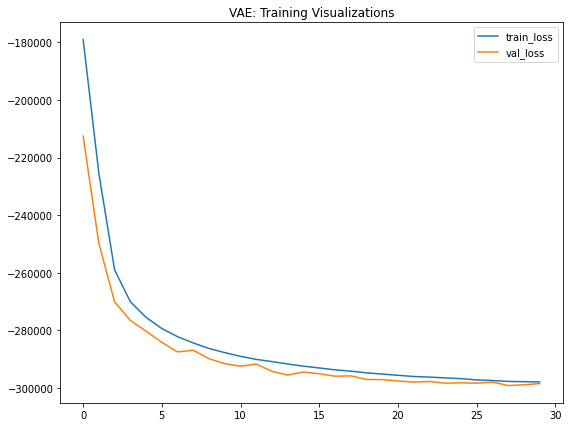

In [38]:
# VAE Training Visualization-
plt.figure(figsize = (9, 7))
plt.plot([train_history[x]['train_loss'] for x in train_history.keys()], label = 'train_loss')
plt.plot([train_history[x]['val_loss'] for x in train_history.keys()], label = 'val_loss')
plt.legend(loc = 'best')
plt.title("VAE: Training Visualizations")
plt.show()

### Reconstruct/Generate images using _trained_ VAE model:

In [39]:
images = images.to(device)

In [41]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [ ]:
# For CPU-
recon_images = recon_images.detach().numpy()
mu = mu.detach().numpy()
log_var = log_var.detach().numpy()

In [ ]:
recon_images.shape, mu.shape, log_var.shape

((64, 784), (64, 5), (64, 5))

In [42]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [43]:
recon_images.shape

(64, 784)

In [44]:
# Reshape images for visualization-
recon_images = recon_images.reshape(-1, 1, 28, 28)

In [45]:
recon_images.shape

(64, 1, 28, 28)

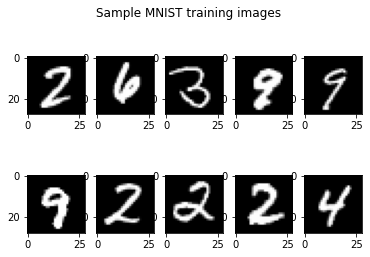

In [46]:
# Print 10 images from training set-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    plt.imshow(images[i][0].cpu(), cmap = 'gray')     # '0' to access first channel
    
plt.suptitle("Sample MNIST training images")
plt.show()

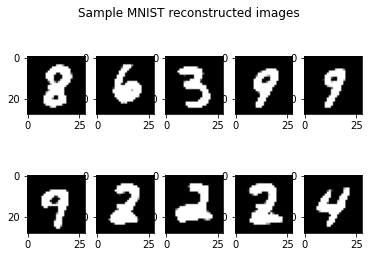

In [47]:
# Print 10 images from reconstructions-
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

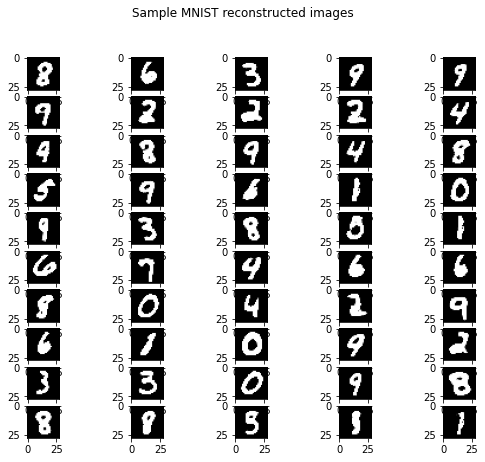

In [48]:
# Print 50 images from reconstructions-
plt.figure(figsize = (9, 7))

for i in range(50):
    plt.subplot(10, 5, i + 1)    # 10 rows & 5 columns
    # plt.imshow(recon_images[i][0].cpu().detach().numpy(), cmap = 'gray')     # '0' to access first channel
    plt.imshow(recon_images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST reconstructed images")
plt.show()

In [ ]:
'''
# Iterating over train loader-
for img, label in train_loader:
    print(img.shape, label.shape)
'''

In [71]:
# Get a batch of training data & it's corresponding labels-
images, labels = next(iter(train_loader))
images = images.to(device)

In [72]:
# Perform forward propagation-
recon_images, mu, log_var = model(images)

In [73]:
# FOR CUDA/GPU-
recon_images = recon_images.detach().cpu().numpy()
mu = mu.detach().cpu().numpy()
log_var = log_var.detach().cpu().numpy()

In [74]:
recon_images.shape, mu.shape, log_var.shape

((64, 784), (64, 5), (64, 5))

In [ ]:
!pip install umap-learn

In [57]:
import umap
import umap.umap_ as umap

In [60]:
reducer = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [61]:
embedding_mu = reducer.fit_transform(mu)
embedding_mu.shape

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(64, 3)

In [62]:
reducer_logvar = umap.UMAP(
    n_neighbors = 15,
    n_components = 3
)

In [63]:
embedding_logvar = reducer.fit_transform(log_var)
embedding_logvar.shape

(64, 3)

In [64]:
import plotly
import plotly.express as px

In [65]:
# Visualize latent space for 'mean'-
fig = px.scatter_3d(
    x = embedding_mu[:, 0], y = embedding_mu[:, 1],
    z = embedding_mu[:, 2],
    # color = y_train
    )
fig.show()

In [66]:
# Visualize latent space for 'log variance'-
fig = px.scatter_3d(
    x = embedding_logvar[:, 0], y = embedding_logvar[:, 1],
    z = embedding_logvar[:, 2],
    # color = y_train
    )
fig.show()